# Capstone 4

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf
import sklearn.metrics
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

Topic: Speaking as a DA from a business that wants to perform better compared to others in the same country, and uncover what they're doing better that we can potentially adopt. I'd also like to make a prediction on products sold based on seller gender, country, # of followers, etc!

The data was scraped from a successful online C2C fashion store with over 9M registered users. The store was first launched in Europe around 2009 then expanded worldwide.

Visitors vs Users:
Visitors do not appear in this dataset. Only registered users are included. "Visitors" cannot purchase an article but can view the catalog.

# Loading and cleaning datasets

In [2]:
# Countries in each dataset written in French. When inspecting on Excel, noticed encryption/accents. Saving to UTF-8,
# and using IFERROR + VLOOKUP to translate country names

In [3]:
# Dealing with encrypted and accented characters:
# Open Excel
# Click “File” and “New”
# Click on the “Data” tab
# Click “From Text” and select the CSV file
# Select “Delimited”
# For “File origin”, select “65001 : Unicode (UTF-8)”
# Click “Next”
# Select “Comma”
# Click “Finish”
# Excel should now show you the CSV file and display the characters correctly.

In [4]:
# Loading revised datasets

In [5]:
pd.set_option('display.max_columns', None)

In [6]:
# Dataset of users and information about their social shopping/behavior

users = pd.read_csv('~/Documents/JONATHANAYALA-CAPSTONE4/DATA/users.csv', encoding='utf8')

users.head(5)

,identifierHash,eng_country,language,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsPassRate,productsWished,productsBought,gender,civilityGenderId,civilityTitle,hasAnyApp,hasAndroidApp,hasIosApp,hasProfilePicture,daysSinceLastLogin,seniority,seniorityAsMonths,seniorityAsYears,countryCode
0,-1.097900e+18,United Kingdom,en,147,10,77,26,174,74.0,104,1,M,1,mr,True,False,True,True,11,3196,106.53,8.88,gb
1,2.347570e+18,Monaco,en,167,8,2,19,170,99.0,0,0,F,2,mrs,True,False,True,True,12,3204,106.80,8.90,mc
2,6.870940e+18,France,fr,137,13,60,33,163,94.0,10,3,F,2,mrs,True,False,True,False,11,3203,106.77,8.90,fr
3,-4.640270e+18,United States,en,131,10,14,122,152,92.0,7,0,F,2,mrs,True,False,True,False,12,3198,106.60,8.88,us
4,-5.175830e+18,United States,en,167,8,0,25,125,100.0,0,0,F,2,mrs,False,False,False,True,22,2854,95.13,7.93,us


The users dataset has duplicate columns for seniority. They each reflect the same thing, so I will be using seniorityAsMonths, and dropping the other two in a new DataFrame.

civilityTitle is...kind of unhelpful. If I wanted to make a comparison between purchases/sales between single and married persons, it would be interesting. But this is one-sided. I only have insight into whether or not females are married. Dropping column.

In [37]:
users_c = users.drop(['civilityTitle', 'seniority', 'seniorityAsYears'], axis=1)
users_c.head()

,identifierHash,eng_country,language,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsPassRate,productsWished,productsBought,gender,civilityGenderId,hasAnyApp,hasAndroidApp,hasIosApp,hasProfilePicture,daysSinceLastLogin,seniorityAsMonths,countryCode
0,-1.097900e+18,United Kingdom,en,147,10,77,26,174,74.0,104,1,M,1,True,False,True,True,11,106.53,gb
1,2.347570e+18,Monaco,en,167,8,2,19,170,99.0,0,0,F,2,True,False,True,True,12,106.80,mc
2,6.870940e+18,France,fr,137,13,60,33,163,94.0,10,3,F,2,True,False,True,False,11,106.77,fr
3,-4.640270e+18,United States,en,131,10,14,122,152,92.0,7,0,F,2,True,False,True,False,12,106.60,us
4,-5.175830e+18,United States,en,167,8,0,25,125,100.0,0,0,F,2,False,False,False,True,22,95.13,us


In [8]:
# Comparison of seller accounts by country and gender

sellers = pd.read_csv('~/Documents/JONATHANAYALA-CAPSTONE4/DATA/sellers.csv', encoding='utf8')

sellers.head(5)

,eng_country,sex,nbsellers,meanproductssold,meanproductslisted,meansellerpassrate,totalproductssold,totalproductslisted,meanproductsbought,meanproductswished,meanproductsliked,totalbought,totalwished,totalproductsliked,meanfollowers,meanfollows,percentofappusers,percentofiosusers,meanseniority
0,Germany,Female,116,4.03,2.72,27.33,468,315,3.05,34.66,35.28,354,4021,4092,9.5,8.9,54.0,49.0,3060.336207
1,Germany,Male,34,2.00,1.00,19.15,68,34,1.62,3.38,31.79,55,115,1081,7.8,8.4,79.0,64.0,3089.058824
2,Armenia,Female,1,0.00,25.00,0.00,0,25,0.00,0.00,1.00,0,0,1,4.0,8.0,NaN,NaN,3201.000000
3,Australia,Female,18,0.94,1.33,10.44,17,24,6.11,17.72,209.28,110,319,3767,7.5,9.3,55.0,55.0,3103.666667
4,Australia,Male,3,6.00,4.00,33.33,18,12,8.00,24.00,38.33,24,72,115,12.7,8.3,66.0,66.0,3085.666667


In [9]:
# Stats about countries with top sellers. Top sellers those with >= 20 products sold
# They represent ~ the top 10% of all seller accounts in the dataset
# (Seller accounts are those who successfully sold at least 1 product)
# These are just insights extracted from the main file!

# Note: incl. countries list only 1 top seller each.

topsellers = pd.read_csv('~/Documents/JONATHANAYALA-CAPSTONE4/DATA/topsellers.csv', encoding='utf8')

topsellers

,eng_country,sellers,topsellers,topsellerratio,femalesellersratio,topfemalesellersratio,femalesellers,malesellers,topfemalesellers,topmalesellers,countrysoldratio,bestsoldratio,toptotalproductssold,totalproductssold,toptotalproductslisted,totalproductslisted,topmeanproductssold,topmeanproductslisted,meanproductssold,meanproductslisted,meanofflinedays,topmeanofflinedays,meanfollowers,meanfollowing,topmeanfollowers,topmeanfollowing
0,Taiwan,1,1,100.0,100.0,100.0,1,0,1,0,1.02,1.02,57,57,56,56,57.000000,56.000000,57.000000,56.000000,11.0,11.0,83.0,8.0,83.0,8.0
1,Slovakia,2,1,50.0,0.0,0.0,0,2,0,1,2.00,1.93,27,28,14,14,27.000000,14.000000,14.000000,7.000000,17.0,15.0,10.5,8.5,15.0,8.0
2,Latvia,4,2,50.0,100.0,100.0,4,0,2,0,2.31,2.25,81,83,36,36,40.500000,18.000000,20.750000,9.000000,120.3,11.5,21.0,52.3,38.0,98.5
3,Bulgaria,9,4,44.4,66.7,100.0,6,3,4,0,2.07,2.10,145,170,69,82,36.250000,17.250000,18.888889,9.111111,98.3,19.0,28.6,31.6,46.3,19.0
4,Cyprus,4,1,25.0,100.0,100.0,4,0,1,0,0.69,0.62,41,56,66,81,41.000000,66.000000,14.000000,20.250000,17.3,11.0,21.3,10.3,39.0,17.0
5,Monaco,5,1,20.0,100.0,100.0,5,0,1,0,7.31,8.95,170,190,19,26,170.000000,19.000000,38.000000,5.200000,51.6,12.0,39.6,8.0,167.0,8.0
6,Romania,13,2,15.4,76.9,50.0,10,3,1,1,0.88,1.26,49,68,39,77,24.500000,19.500000,5.230769,5.923077,121.6,11.0,10.9,11.5,30.0,32.0
7,Luxembourg,7,1,14.3,85.7,100.0,6,1,1,0,5.38,NaN,30,43,0,8,30.000000,0.000000,6.142857,1.142857,73.6,11.0,15.9,8.4,52.0,3.0
8,Spain,119,13,10.9,81.5,76.9,97,22,10,3,1.67,2.02,607,990,301,594,46.692308,23.153846,8.319328,4.991597,202.4,30.5,16.1,14.6,53.2,14.5
9,Italy,347,35,10.1,71.5,65.7,248,99,23,12,1.27,1.29,1389,2820,1077,2218,39.685714,30.771429,8.126801,6.391931,141.8,26.5,16.1,54.6,63.4,429.3


# EDA

In [10]:
# users

In [11]:
users.shape

(98913, 23)

In [12]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98913 entries, 0 to 98912
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   identifierHash       98913 non-null  float64
 1   eng_country          98913 non-null  object 
 2   language             98913 non-null  object 
 3   socialNbFollowers    98913 non-null  int64  
 4   socialNbFollows      98913 non-null  int64  
 5   socialProductsLiked  98913 non-null  int64  
 6   productsListed       98913 non-null  int64  
 7   productsSold         98913 non-null  int64  
 8   productsPassRate     98913 non-null  float64
 9   productsWished       98913 non-null  int64  
 10  productsBought       98913 non-null  int64  
 11  gender               98913 non-null  object 
 12  civilityGenderId     98913 non-null  int64  
 13  civilityTitle        98913 non-null  object 
 14  hasAnyApp            98913 non-null  bool   
 15  hasAndroidApp        98913 non-null 

In [13]:
users.describe()

,identifierHash,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsPassRate,productsWished,productsBought,civilityGenderId,daysSinceLastLogin,seniority,seniorityAsMonths,seniorityAsYears
count,9.891300e+04,98913.000000,98913.000000,98913.000000,98913.000000,98913.000000,98913.000000,98913.000000,98913.000000,98913.000000,98913.000000,98913.000000,98913.000000,98913.000000
mean,-6.692037e+15,3.432269,8.425677,4.420743,0.093304,0.121592,0.812303,1.562595,0.171929,1.773993,581.291236,3063.771870,102.125583,8.510424
std,5.330807e+18,3.882383,52.839572,181.030569,2.050144,2.126895,8.500205,25.192793,2.332266,0.428679,208.855888,168.298621,5.609735,0.467863
min,-9.223100e+18,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,11.000000,2852.000000,95.070000,7.920000
25%,-4.622890e+18,3.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,572.000000,2857.000000,95.230000,7.940000
50%,-1.337990e+15,3.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,694.000000,3196.000000,106.530000,8.880000
75%,4.616390e+18,3.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,702.000000,3201.000000,106.700000,8.890000
max,9.223330e+18,744.000000,13764.000000,51671.000000,244.000000,174.000000,100.000000,2635.000000,405.000000,3.000000,709.000000,3205.000000,106.830000,8.900000


In [14]:
users['hasAnyApp'].value_counts()

# Roughly 74% of registered users do not have a fashion store app installed.

False    72739
True     26174
Name: hasAnyApp, dtype: int64

In [15]:
# Breakdown of users by spoken language
grouped = users.groupby(users['language'])['identifierHash'].count().reset_index()
grouped.sort_values('identifierHash', ascending=False)

# (98913 total) 52% of users speak English, with about 27% French

,language,identifierHash
1,en,51564
3,fr,26372
4,it,7766
0,de,7178
2,es,6033


In [16]:
# Breakdown of users by gender
users.groupby(users['gender'])['identifierHash'].count()

gender
F    76121
M    22792
Name: identifierHash, dtype: int64

In [17]:
# What is civilityGenderId 3?
users.groupby(users['civilityGenderId'])['identifierHash'].count()

civilityGenderId
1    22792
2    75684
3      437
Name: identifierHash, dtype: int64

In [18]:
# Looks like a genderid of 3 means 'miss'. Let's confirm.
users.loc[users['civilityGenderId'] == 3]

,identifierHash,eng_country,language,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsPassRate,productsWished,productsBought,gender,civilityGenderId,civilityTitle,hasAnyApp,hasAndroidApp,hasIosApp,hasProfilePicture,daysSinceLastLogin,seniority,seniorityAsMonths,seniorityAsYears,countryCode
6,6.743610e+17,Sweden,en,121,0,1140,31,108,94.0,531,105,F,3,miss,True,True,False,False,11,3198,106.60,8.88,se
9,3.908240e+18,United Kingdom,en,57,8,45,123,92,74.0,6,2,F,3,miss,True,False,True,True,11,2856,95.20,7.93,gb
54,2.451240e+17,United Kingdom,en,82,12,150,5,37,50.0,7,5,F,3,miss,True,False,True,False,106,2857,95.23,7.94,gb
86,-1.554730e+17,Italy,it,21,9,3,20,27,85.0,0,0,F,3,miss,True,True,True,False,11,3204,106.80,8.90,it
112,-3.988620e+18,United Kingdom,en,20,8,203,13,22,100.0,19,5,F,3,miss,False,False,False,True,14,2853,95.10,7.92,gb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95889,-6.744440e+18,Ireland,en,3,9,136,0,0,0.0,15,9,F,3,miss,False,False,False,True,16,3204,106.80,8.90,ie
96118,3.626570e+18,France,fr,3,8,0,0,0,0.0,0,0,F,3,miss,False,False,False,True,693,3204,106.80,8.90,fr
96302,-4.635660e+18,United Kingdom,en,3,8,0,0,0,0.0,0,0,F,3,miss,False,False,False,True,509,3204,106.80,8.90,gb
96717,1.033250e+17,United Kingdom,en,3,8,0,0,0,0.0,0,0,F,3,miss,False,False,False,True,186,3204,106.80,8.90,gb


In [19]:
# Interesting. A genderid of 2 is 'mrs' while 3 is 'ms'. They count married and unmarried as
# two different genders. Perhaps this segmentation of married and non-married women is helpful.
# Different gender codes, even though the gender column is a binary option
users.groupby(users['civilityTitle'])['identifierHash'].count()

civilityTitle
miss      437
mr      22792
mrs     75684
Name: identifierHash, dtype: int64

In [ ]:
# How many of these users are actually active, whether they're buying, selling, or interacting?
# There are a couple ways to filter this. A completely inactive user will have no social engagement,
# purchases made/products wishlisted, or sales made/products on offer. Let's get rid of these first

In [ ]:
# Even with these filtered out, daysSinceLastLogin should be investigated

In [ ]:
# Once this is discovered, what country's shops should be the focus? Who is your storefront?
# How will you compare and investigate to determine how best to compete with top sellers?

# Univariate-Numeric Visualizations

Excluding users['identifierHash'] as it hugely skews visualizations, and serves only as a unique identifier. Discovering relationships is tricky, as there are 12 numeric vbls to work with.

In [20]:
# Using .describe() automatically identifies numerical columns for you.

In [21]:
u_numeric_vars = ['socialNbFollowers', 'socialNbFollows',
                  'socialProductsLiked', 'productsListed', 'productsSold',
                  'productsPassRate', 'productsWished', 'productsBought', 
                   'daysSinceLastLogin', 'seniority', 'seniorityAsMonths', 'seniorityAsYears']

u_categorical_vars = ['eng_country', 'language', 'gender', 
                      'civilityGenderId', 'civilityTitle', 'hasAnyApp', 
                      'hasAndroidApp', 'hasIosApp', 'hasProfilePicture', 'countryCode']

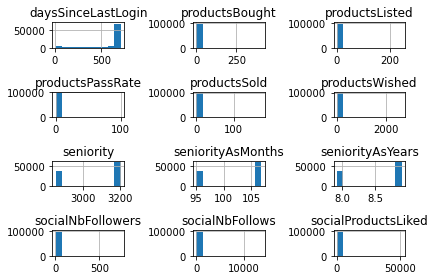

In [22]:
# Histograms
# sns.set(rc={'figure.figsize': (16,3)})

ax = users[u_numeric_vars].hist(bins=10)
plt.tight_layout()

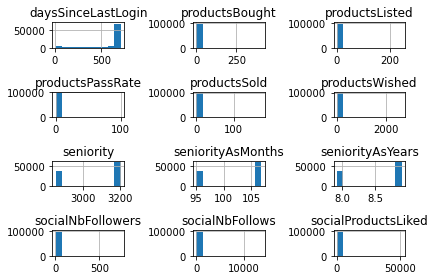

In [23]:
ax = users[u_numeric_vars].hist(bins=10)
plt.tight_layout()

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 12 Text major ticklabel objects>)

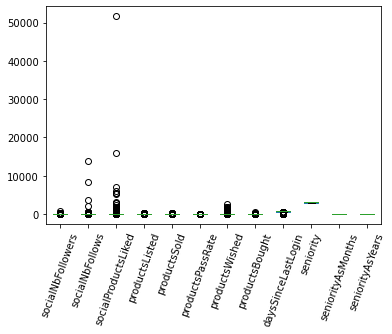

In [24]:
# Boxplots - visualize the minimum, 
#first quartile, median, third quartile, and maximum

users[u_numeric_vars].plot(kind='box')
plt.xticks(rotation=70)

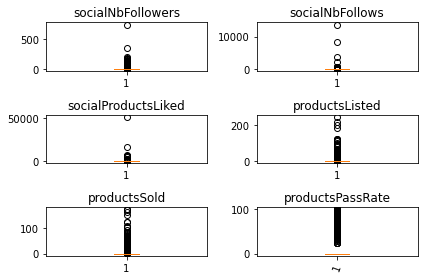

In [25]:
# To better visualize the boxplots, let's plot them one at a time.
fig, axes = plt.subplots(3,2)
for ax, var in zip(axes.ravel(), u_numeric_vars):
    ax.boxplot(users[var])
    ax.set_title(var)
    plt.xticks(rotation=70)
plt.tight_layout()

# Univariate-Categorical Visualizations

# Numeric vs Numeric Viz

/Users/jonathanayala/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  after removing the cwd from sys.path.


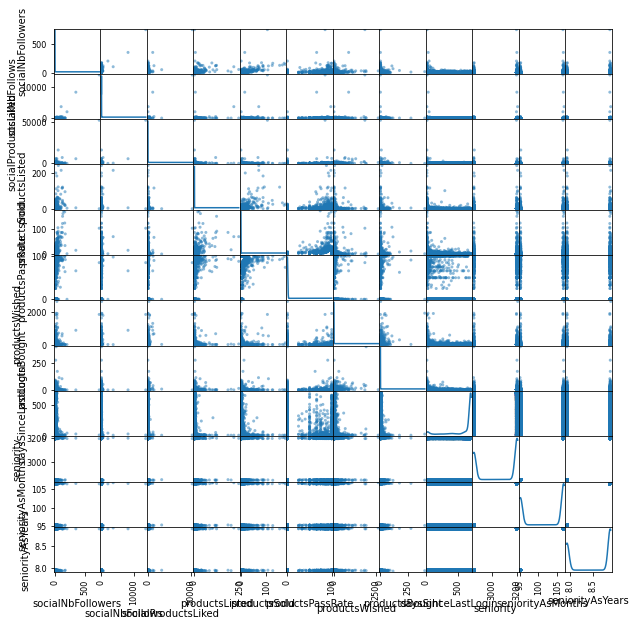

In [26]:
# Scatterplot matrix
from pandas.plotting import scatter_matrix
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax = scatter_matrix(users[u_numeric_vars], ax=ax, diagonal='kde')

In [27]:
# Creating new df w/ only the numerical vars
num_df = users[['socialNbFollowers', 'socialNbFollows',
                  'socialProductsLiked', 'productsListed', 'productsSold',
                  'productsPassRate', 'productsWished', 'productsBought', 
                   'daysSinceLastLogin', 'seniority', 'seniorityAsMonths', 'seniorityAsYears']]
num_df

,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsPassRate,productsWished,productsBought,daysSinceLastLogin,seniority,seniorityAsMonths,seniorityAsYears
0,147,10,77,26,174,74.0,104,1,11,3196,106.53,8.88
1,167,8,2,19,170,99.0,0,0,12,3204,106.80,8.90
2,137,13,60,33,163,94.0,10,3,11,3203,106.77,8.90
3,131,10,14,122,152,92.0,7,0,12,3198,106.60,8.88
4,167,8,0,25,125,100.0,0,0,22,2854,95.13,7.93
...,...,...,...,...,...,...,...,...,...,...,...,...
98908,3,8,0,0,0,0.0,0,0,708,3204,106.80,8.90
98909,3,8,0,0,0,0.0,0,0,695,3204,106.80,8.90
98910,3,8,0,0,0,0.0,0,0,520,3204,106.80,8.90
98911,3,8,0,0,0,0.0,0,0,267,3204,106.80,8.90


The scatterplot matrix makes it difficult to find related elements when there are so many. Let's use a correlation matrix!

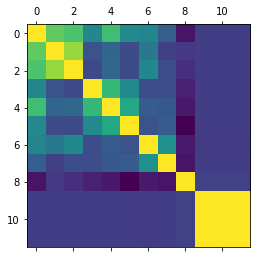

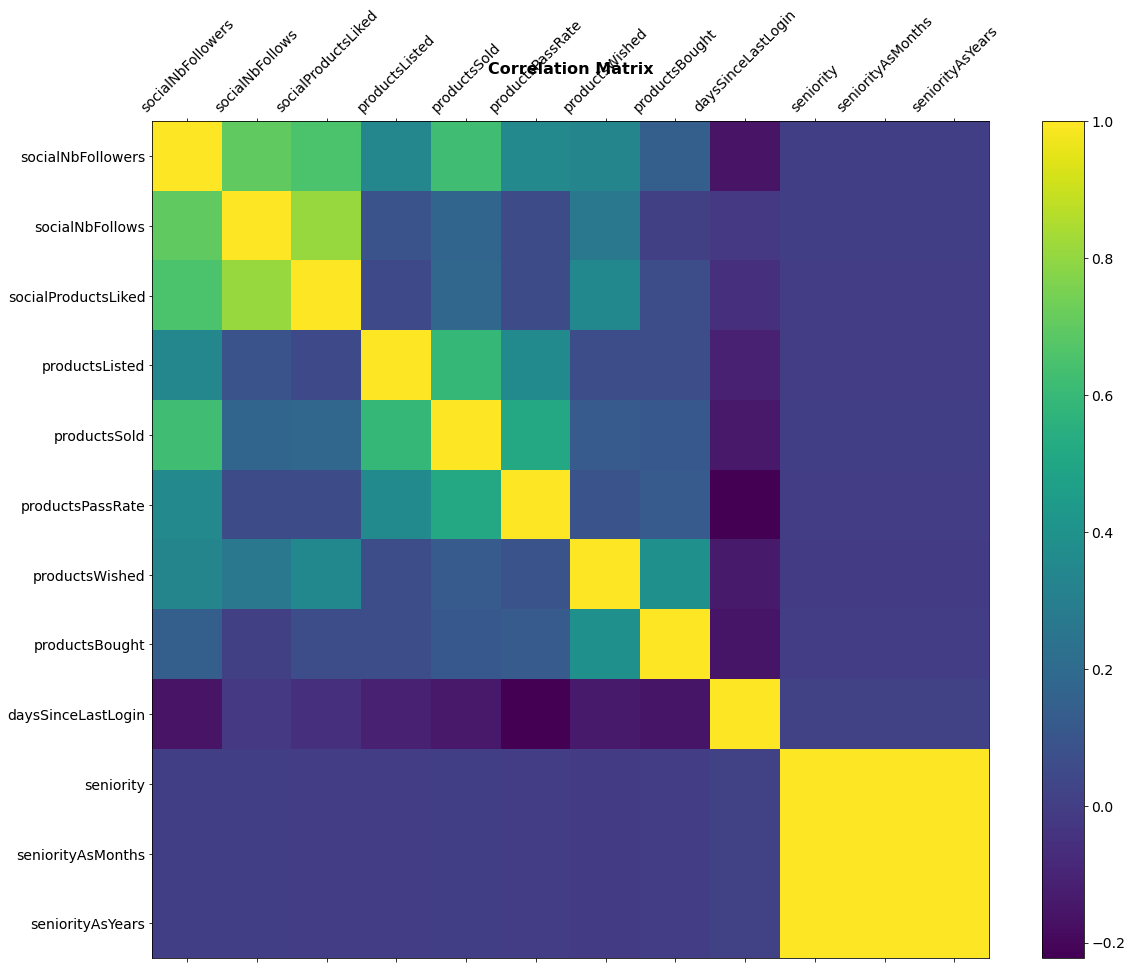

In [28]:
# Correlation Matrix

plt.matshow(num_df.corr())

f = plt.figure(figsize=(19, 15))
plt.matshow(num_df.corr(), fignum=f.number)
plt.xticks(range(num_df.shape[1]), num_df.columns, fontsize=14, rotation=45)
plt.yticks(range(num_df.shape[1]), num_df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16, fontweight='bold')

plt.show()

In [29]:
# sellers

In [30]:
sellers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   eng_country          70 non-null     object 
 1   sex                  72 non-null     object 
 2   nbsellers            73 non-null     int64  
 3   meanproductssold     73 non-null     float64
 4   meanproductslisted   73 non-null     float64
 5   meansellerpassrate   73 non-null     float64
 6   totalproductssold    73 non-null     int64  
 7   totalproductslisted  73 non-null     int64  
 8   meanproductsbought   73 non-null     float64
 9   meanproductswished   73 non-null     float64
 10  meanproductsliked    73 non-null     float64
 11  totalbought          73 non-null     int64  
 12  totalwished          73 non-null     int64  
 13  totalproductsliked   73 non-null     int64  
 14  meanfollowers        73 non-null     float64
 15  meanfollows          73 non-null     float

In [31]:
sellers.describe()

,nbsellers,meanproductssold,meanproductslisted,meansellerpassrate,totalproductssold,totalproductslisted,meanproductsbought,meanproductswished,meanproductsliked,totalbought,totalwished,totalproductsliked,meanfollowers,meanfollows,percentofappusers,percentofiosusers,meanseniority
count,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,66.000000,65.000000,73.000000
mean,111.739726,4.984110,4.177671,26.382329,494.260274,379.273973,3.266575,40.527397,72.186986,225.616438,1874.424658,6601.931507,12.583562,16.475342,68.015152,61.492308,3070.617187
std,412.253126,8.091924,7.484078,21.453931,1809.983142,1410.134078,5.211880,113.551020,134.051376,824.771679,7067.534787,26250.135826,12.190946,25.093557,19.716836,22.041242,100.929973
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,8.000000,20.000000,12.000000,2855.000000
25%,2.000000,1.200000,1.000000,0.000000,3.000000,3.000000,0.000000,1.130000,6.330000,0.000000,4.000000,15.000000,7.500000,8.200000,57.500000,50.000000,3043.909091
50%,5.000000,2.790000,2.250000,29.460000,24.000000,14.000000,1.290000,7.000000,27.750000,15.000000,80.000000,333.000000,9.500000,9.000000,66.000000,57.000000,3084.600000
75%,22.000000,5.250000,4.150000,37.000000,107.000000,82.000000,3.330000,26.400000,69.990000,77.000000,817.000000,1081.000000,13.400000,12.300000,75.000000,66.000000,3130.600000
max,2719.000000,57.000000,56.000000,98.000000,12027.000000,9229.000000,24.670000,707.000000,792.000000,5490.000000,45611.000000,160647.000000,83.000000,157.000000,100.000000,100.000000,3204.000000


In [32]:
s_numeric_vars = []
s_categorical_vars = []

In [33]:
# topsellers

In [34]:
topsellers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   eng_country             19 non-null     object 
 1   sellers                 19 non-null     int64  
 2   topsellers              19 non-null     int64  
 3   topsellerratio          19 non-null     float64
 4   femalesellersratio      19 non-null     float64
 5   topfemalesellersratio   19 non-null     float64
 6   femalesellers           19 non-null     int64  
 7   malesellers             19 non-null     int64  
 8   topfemalesellers        19 non-null     int64  
 9   topmalesellers          19 non-null     int64  
 10  countrysoldratio        19 non-null     float64
 11  bestsoldratio           18 non-null     float64
 12  toptotalproductssold    19 non-null     int64  
 13  totalproductssold       19 non-null     int64  
 14  toptotalproductslisted  19 non-null     int6

In [35]:
topsellers.describe()

,sellers,topsellers,topsellerratio,femalesellersratio,topfemalesellersratio,femalesellers,malesellers,topfemalesellers,topmalesellers,countrysoldratio,bestsoldratio,toptotalproductssold,totalproductssold,toptotalproductslisted,totalproductslisted,topmeanproductssold,topmeanproductslisted,meanproductssold,meanproductslisted,meanofflinedays,topmeanofflinedays,meanfollowers,meanfollowing,topmeanfollowers,topmeanfollowing
count,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,18.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000
mean,99.578947,6.631579,20.968421,78.778947,80.963158,75.368421,24.210526,5.105263,1.526316,2.032632,1.960556,309.105263,610.631579,196.157895,401.157895,50.026688,30.124714,12.966926,8.582865,122.631579,23.757895,19.752632,17.389474,55.310526,56.389474
std,178.948570,9.804820,24.430174,22.167182,26.052025,131.976097,47.390317,7.194865,2.874571,1.616621,1.839704,419.088415,933.298524,296.793281,645.312092,34.374679,19.263995,13.502800,12.208144,73.153940,20.889453,17.128448,14.551552,36.883012,103.303425
min,1.000000,1.000000,3.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.690000,0.620000,20.000000,28.000000,0.000000,8.000000,20.000000,0.000000,3.722222,1.142857,11.000000,11.000000,7.000000,8.000000,15.000000,3.000000
25%,6.000000,1.000000,6.450000,74.300000,71.800000,5.500000,0.500000,1.000000,0.000000,1.230000,1.267500,44.000000,62.000000,31.000000,46.000000,28.500000,18.500000,5.167766,2.930594,62.600000,11.000000,10.800000,8.700000,36.650000,8.550000
50%,13.000000,2.000000,10.100000,78.700000,85.700000,10.000000,3.000000,1.000000,1.000000,1.590000,1.425000,81.000000,170.000000,56.000000,81.000000,41.000000,21.380952,8.126801,5.500000,121.600000,12.700000,15.100000,10.200000,46.300000,14.500000
75%,112.000000,5.500000,22.500000,92.850000,100.000000,88.000000,24.000000,4.500000,1.000000,2.015000,2.080000,420.000000,751.500000,228.500000,429.000000,56.700000,39.500000,14.000000,7.109375,172.800000,28.500000,20.400000,19.750000,58.300000,36.500000
max,713.000000,35.000000,100.000000,100.000000,100.000000,523.000000,190.000000,23.000000,12.000000,7.310000,8.950000,1389.000000,3014.000000,1077.000000,2218.000000,170.000000,71.333333,57.000000,56.000000,266.100000,79.400000,83.000000,54.600000,167.000000,429.300000


In [36]:
ts_numeric_vars = []
ts_categorical_vars = [] 